In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

# Загружаем выборку Diamonds

1. PRICE: price in US dollars (326-18,823)
2. CARAT: weight of the diamond (0.2--5.01)
3. CUT: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
4. COLOR: diamond colour, from J (worst) to D (best)
5. CLARITY: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
6. X: length in mm (0--10.74)
7. Y: width in mm (0--58.9)
8. Z: depth in mm (0--31.8)
9. DEPTH: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
10. TABLE: width of top of diamond relative to widest point (43--95)

In [2]:
diamonds_df = pd.read_csv('diamonds.csv')

In [3]:
diamonds_df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


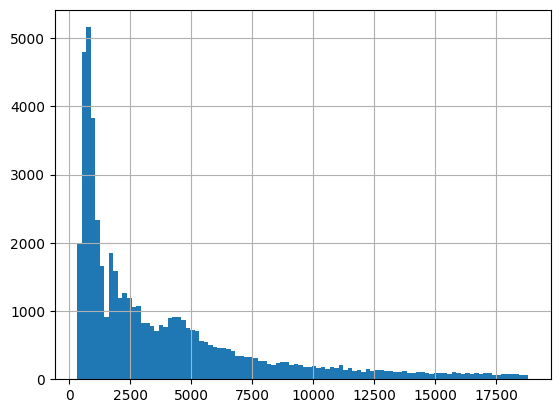

In [4]:
plt.hist(diamonds_df['price'], bins=100)
plt.grid();

# Подготовка данных

In [5]:
features = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']
target = ['price']

In [6]:
cut_transform = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
clarity_transform = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
color_transorm = {'D': 0, 'E': 1, 'F': 2, 'G': 3, 'H': 4, 'I': 5, 'J': 6}

In [7]:
diamonds_df['cut'] = diamonds_df['cut'].apply(lambda x: cut_transform.get(x))
diamonds_df['color'] = diamonds_df['color'].apply(lambda x: color_transorm.get(x))
diamonds_df['clarity'] = diamonds_df['clarity'].apply(lambda x: clarity_transform.get(x))

In [8]:
X = diamonds_df[features].copy().values
y = diamonds_df[target].values

In [9]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=47, test_size=0.3)

# Обучаем модель линейной регрессии

In [11]:
reg = LinearRegression().fit(X_train, y_train)

In [12]:
y_pred = reg.predict(X_test)

In [13]:
score = r2_score(y_pred, y_test)

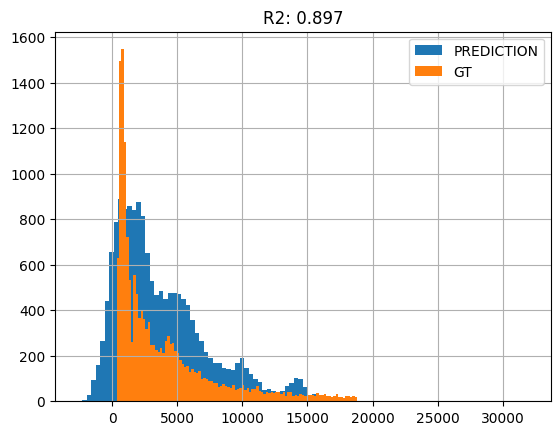

In [14]:
plt.title(f'R2: {str(score)[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid();

# Создаём модель MLP для задачи регрессии

In [15]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu(x):
    return np.maximum(x, 0)

def relu_derivative(x):
    return (x > 0).astype(float)

def leaky_relu(x):
    return np.maximum(x, 0.1*x)

def leaky_relu_derivative(x):
    return 0.1 + 0.9 * (x > 0)

In [16]:
from numpy.random import randn
import copy

class MLPRegressor:
    def __init__(
        self,
        hidden_layer_sizes=(100,),
        learning_rate=0.0001,
        max_iter=2000,
        batch_size = 64,
        activation = 'leaky_relu',
        tol = -1,
        random_state = 42
    ):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.batch_size = batch_size
        if activation == 'sigmoid':
            self._act = sigmoid
            self._act_derivative = sigmoid_derivative
        elif activation == 'leaky_relu':
            self._act = leaky_relu
            self._act_derivative = leaky_relu_derivative
        else:
            self._act = relu
            self._act_derivative = relu_derivative            
        self.tol = tol
        self.random_state = random_state
        
        
    """
            начальная инициализация весов
    """
    def _params_init(self, X, y):
        np.random.seed(self.random_state)
        sigma = 1
        # инициализация матриц весов
        self._W = [sigma * randn(X.shape[1], self.hidden_layer_sizes[0])] # матрица весов первого слоя
        for i in range(len(self.hidden_layer_sizes) - 1): # матрицы весов внутренних слоев
            self._W.append(sigma * randn(self.hidden_layer_sizes[i], self.hidden_layer_sizes[i+1]))
        self._W.append(sigma * randn(self.hidden_layer_sizes[-1], y.shape[1])) # матрица весов последнего слоя  
        
        # инициализация векторов смещений
        self._b = [np.zeros((1, size)) for size in self.hidden_layer_sizes]
        self._b.append(np.zeros((1, y.shape[1])))
        
        
    """
            прямое распространение
    """
    def _go_forward(self, X):
        signal = X
        out = [X]  # сохраняем выходы нейронной сети на каждом слое
        for layer in range(len(self.hidden_layer_sizes)):
            signal = self._act(np.add(np.dot(signal, self._W[layer]), self._b[layer]))
            out.append(signal)
        y_pred = np.add(np.dot(signal, self._W[-1]), self._b[-1]) # на последнем слое тождественная функция активации
        return y_pred, out
    
    
    """
            получение градиента обратным распространением ошибки
    """         
    def _back_propagation(self, X, y):
        gradW = []
        gradb = []
        
        y_pred, out = self._go_forward(X)
        
        # вычисление градиента на последнем слое
        
        coeff = 2*(y_pred-y)
        
        dL_dW = [out[-1][sample].reshape(-1,1) * coeff[sample] for sample in range(self.batch_size)]
        dL_db = coeff
        dL_dx = [coeff[sample] * self._W[-1].T for sample in range(self.batch_size)]
    
        gradW.append(sum(dL_dW) / self.batch_size)
        gradb.append(sum(dL_db) / self.batch_size)
        
        # вычисление градиента на предыдущих слоях
        for layer in range(2, len(self.hidden_layer_sizes) + 2):
            coeff = [(dL_dx[sample] * self._act_derivative(np.add(np.dot(out[-layer][sample], self._W[-layer]), self._b[-layer]))).reshape(1,-1) 
                     for sample in range(self.batch_size)]
            
            dL_dW = [np.dot(out[-layer][sample].T.reshape(-1,1), coeff[sample])
                     for sample in range(self.batch_size)]
            dL_db = coeff
            dL_dx = [np.dot(coeff[sample], self._W[-layer].T) for sample in range(self.batch_size)]
            
            gradW.append(sum(dL_dW) / self.batch_size)
            gradb.append(sum(dL_db) / self.batch_size)
                       
        return gradW[::-1], gradb[::-1]
    
    
    """
            обучение
    """   
    def train(self, X, y, plot=True):
        self._params_init(X, y)
        
        counter = 0
        self.train_errors = []
        self.test_errors = []
        self.W_history = []
        
        # скользящее среднее
        moving_average = mean_squared_error(self.predict(X), y)
        
        epoch_size = X.shape[0] // self.batch_size
        
        while counter < self.max_iter and moving_average > self.tol:
            counter += 1
            if plot and counter % epoch_size == 0: #эпохи:
                y_train_pred = self.predict(X_train)
                y_test_pred = self.predict(X_test)
                self.train_errors.append(mean_squared_error(y_train_pred, y_train))
                self.test_errors.append(mean_squared_error(y_test_pred, y_test))
                self.W_history.append(copy.deepcopy(self._W))
            
            batch = np.random.choice(X.shape[0], self.batch_size, replace=False)
            X_batch = X[batch]
            y_batch = y[batch]
            
            gradW, gradb = self._back_propagation(X_batch, y_batch)
                                  
            for i in range(len(self.hidden_layer_sizes) + 1):
                self._W[i] -= self.learning_rate * gradW[i] # * (1+self.max_iter - counter) / (1 + self.max_iter)
                self._b[i] -= self.learning_rate * gradb[i] #* (1+self.max_iter - counter) / (1 + self.max_iter)
                
            #lam = 0.02
            #moving_average = lam * mean_squared_error(self.predict(X_batch), y_batch) + (1-lam) * moving_average
            
    def predict(self, X):
        signal = X
        for layer in range(len(self.hidden_layer_sizes)):   
            signal = self._act(np.add(np.dot(signal, self._W[layer]), self._b[layer]))
        y_pred = np.add(np.dot(signal, self._W[-1]), self._b[-1]) # на последнем слое тождественная функция активации
        return y_pred

In [17]:
# # time 5 s, r2 = 0.951
# net = MLPRegressor(random_state = 79)


# # time = 15 s, r2 = 0.968 
net = MLPRegressor(
        hidden_layer_sizes=(100,10),
        learning_rate=0.000005,
        max_iter=4000)


# # time = 1 min, r2 = 0.978 
# net = MLPRegressor(
#         hidden_layer_sizes=(100,10),
#         learning_rate=0.000005,
#         max_iter = 10000,
#         batch_size = 128)

%time net.train(X_train, y_train)

CPU times: total: 15.2 s
Wall time: 13.7 s


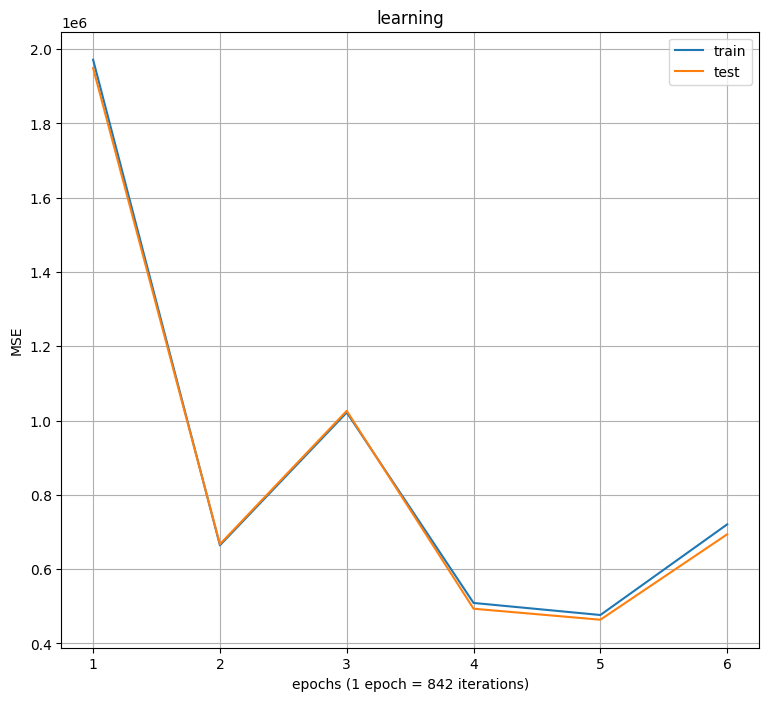

In [18]:
plt.figure(figsize=(9,8))
plt.title('learning')
plt.xlabel(f'epochs (1 epoch = {X.shape[0] // net.batch_size} iterations)')
plt.ylabel('MSE')
epochs = range(1,len(net.train_errors)+1)
plt.plot(epochs, net.train_errors, label = 'train')
plt.plot(epochs, net.test_errors, label = 'test')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

##### Gridsearch лучшего random state

In [19]:
# %%time
# scores = []
# params = []
# for r in range(100):
#     net = MLPRegressor(random_state = r)
#     net.train(X_train, y_train, plot = False)
#     scores.append(r2_score(net.predict(X_test), y_test))
# print(f'max = {np.max(scores)} with r = {np.argmax(scores)}')

# Проверяем модель MLP на выборке Diamonds

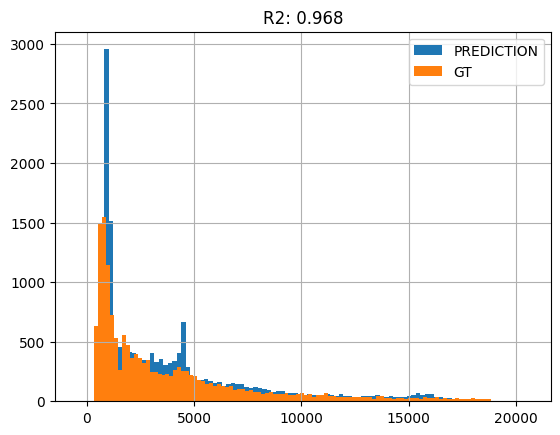

In [20]:
y_pred = net.predict(X_test)
score = r2_score(y_pred, y_test)
plt.title(f'R2: {str(score)[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid();

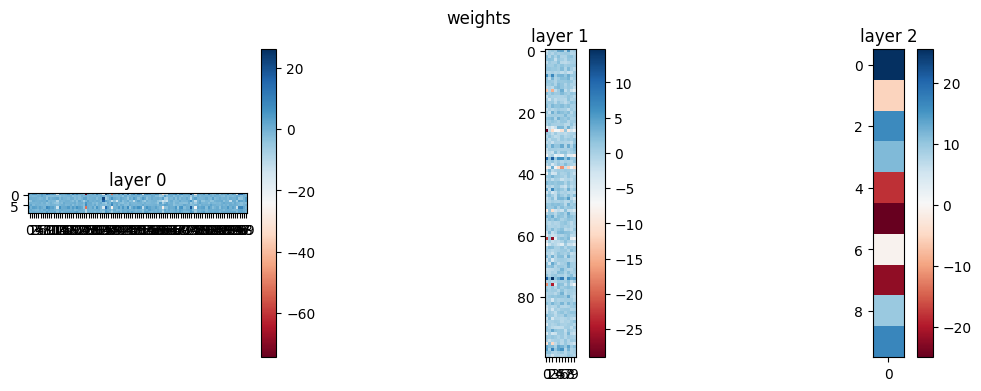

In [21]:
fig = plt.figure(figsize=(12, 4))
plt.suptitle('weights')
for layer in range(len(net.hidden_layer_sizes)+1):
    plt.subplot(1, len(net.hidden_layer_sizes)+1, layer+1)
    plt.xticks(np.arange(0, 100))
    plt.title(label='layer ' + str(layer))
    plt.imshow(net._W[layer], cmap='RdBu', interpolation='nearest')
    plt.colorbar()
plt.show()

In [22]:
%matplotlib
import matplotlib.pyplot as plt
import time

min_max_weights = [[np.min(net.W_history[iteration][layer]), np.max(net.W_history[iteration][layer])] for iteration in range(len(net.W_history)) for layer in range(len(net.hidden_layer_sizes)+1)]
min_weight = np.min(min_max_weights)
max_weight = np.max(min_max_weights)
plt.ion()

for iteration in range(len(net.W_history)):
    plt.clf()
    
    plt.suptitle('W, iteration = ' + str(iteration), horizontalalignment = 'left')
    for layer in range(len(net.hidden_layer_sizes)+1):  
        plt.subplot(1, len(net.hidden_layer_sizes)+1, layer+1)
        plt.xticks(np.arange(0, 100))
        plt.title(label='layer ' + str(layer))
        plt.imshow(net.W_history[iteration][layer], cmap='RdBu', interpolation='nearest',vmin=min_weight, vmax=max_weight)
    plt.colorbar(location = 'bottom') 
    
    plt.draw()
    plt.gcf().canvas.flush_events()
    
    #time.sleep(5)
    
plt.ioff()
plt.show()
%matplotlib inline

Using matplotlib backend: <object object at 0x000001D5195599C0>
